In [1]:
import pandas as pd
import numpy as np
import re
import bisect
import seaborn as sns
import scipy
import scipy.cluster.hierarchy as sch
import plotly.express as px
import matplotlib.pyplot as plt
import networkx as nx
import plotly.figure_factory as ff
import plotly.graph_objs as go

from itertools import chain
from math import pi
from sklearn import preprocessing
from GGLasso.gglasso.problem import glasso_problem
from utils import transform_features, scale_array_by_diagonal
from utils import PCA

from scipy import stats
from scipy.spatial import distance

from networkx.utils import cuthill_mckee_ordering

from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, HoverTool, LabelSet, PointDrawTool
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import RdBu, Blues8
from bokeh.models import HoverTool, Panel, Tabs, ColorBar, LinearColorMapper
from bokeh.layouts import row

from latentcor import gen_data, get_tps, latentcor

In [2]:
def PCA(X, L, inverse=True):
    sig, V = np.linalg.eigh(L)

    # sort eigenvalues in descending order
    sig = sig[::-1]
    V = V[:, ::-1]

    ind = np.argwhere(sig > 1e-9)

    if inverse:
        loadings = V[:, ind] @ np.diag(np.sqrt(1 / sig[ind]))
    else:
        loadings = V[:, ind] @ np.diag(np.sqrt(sig[ind]))

    # compute the projection
    zu = X.values @ loadings

    return zu, loadings, np.round(sig[ind].squeeze(), 3)

In [3]:
def _make_heatmap(data: pd.DataFrame(), title: str = None, labels_dict: dict=None, labels_dict_reversed: dict=None,
                  width: int = 1500, height: int = 1500, label_size: str = "5pt", not_low_rank: bool = True):
    nlabels = len(labels_dict)
    df = data.iloc[::-1] # rotate matrix 90 degrees
    df = pd.DataFrame(df.stack(), columns=['covariance']).reset_index()
    df.columns = ["taxa_y", "taxa_x", "covariance"]
    if not_low_rank:
        df = df.replace({"taxa_x": labels_dict, "taxa_y": labels_dict})

    color_list, colors = _get_colors(df=df, n_colors=11)
    min_value = df['covariance'].min()
    max_value = df['covariance'].max()
    mapper = LinearColorMapper(palette=colors, low=min_value, high=max_value)
#     mapper = LinearColorMapper(palette=colors, low=-1, high=1)
    color_bar = ColorBar(color_mapper=mapper, location=(0, 0))

    bottom, top, left, right = _get_bounds(nlabels=nlabels)

    source = ColumnDataSource(dict(top=top, bottom=bottom, left=left, right=right, color_list=color_list,
                                   taxa_x=df['taxa_x'], taxa_y=df['taxa_y'], covariance=df['covariance']))

    bokeh_tools = ["save, zoom_in, zoom_out, wheel_zoom, box_zoom, crosshair, reset, hover"]

    p = figure(plot_width=width, plot_height=height, x_range=(0, nlabels), y_range=(0, nlabels),
               title=title, title_location='above', x_axis_location="below",
               tools=bokeh_tools, toolbar_location='left')

    p.quad(top="top", bottom="bottom", left="left", right="right", line_color='white', color="color_list",
           source=source)
    p.xaxis.major_label_orientation = pi / 4
    p.yaxis.major_label_orientation = "horizontal"
    p.title.text_font_size = "24pt"
    p.add_layout(color_bar, 'right')
    p.toolbar.autohide = True

    p.xaxis.ticker = list(range(0, nlabels))
    p.yaxis.ticker = list(range(0, nlabels))
    if not_low_rank:
        p.xaxis.major_label_overrides = labels_dict
        p.yaxis.major_label_overrides = labels_dict_reversed
    p.xaxis.major_label_text_font_size = label_size
    p.yaxis.major_label_text_font_size = label_size

    hover = p.select(dict(type=HoverTool))
    hover.tooltips = [
        ("taxa_x", "@taxa_x"),
        ("taxa_y", "@taxa_y"),
        ("covariance", "@covariance"),
    ]

    return p

In [149]:
def plot_network(G, title, width, height, node_size=None, amplify_x=10):
    #Establish which categories will appear when hovering over each node
    HOVER_TOOLTIPS = [("Character", "@index")]
    hover = HoverTool(tooltips=[('','@index')])
    tools = ["save, zoom_in, zoom_out, wheel_zoom, box_zoom, crosshair, reset, hover, pan"]

    #Create a plot — set dimensions, toolbar, and title
    plot = figure(tooltips = HOVER_TOOLTIPS, plot_width=width, plot_height=height,
                  tools=tools, active_scroll='wheel_zoom',
                x_range=Range1d(-10.1, 10.1), 
                  y_range=Range1d(-10.1, 10.1), title=title)
    
    
    
    color_map = ["#88CCEE" if "ASV" in j else "#DDCC77" for j in G.nodes()] 
    nx.set_node_attributes(G, {j: {'color': color_map[i]} for i, j in enumerate(G.nodes())})

    if node_size is not None:
        n_degrees = {k: 15*v for k,v in G.degree()} 
        nx.set_node_attributes(G, n_degrees, 'node_size')
        node_size = 'node_size'
    else:
        node_size = 40

    network_graph = from_networkx(G, nx.spring_layout, scale=10, center=(0, 0))


    #Set node size and color
    network_graph.node_renderer.glyph = Circle(size=node_size,  fill_color="color")
    
    #Set edge width and color green - positive, red - negative
    network_graph.edge_renderer.data_source.data["line_width"] = [G.get_edge_data(a,b)['covariance']*amplify_x for a, b in G.edges()]  ### amplify edges strengh
    network_graph.edge_renderer.data_source.data["line_color"] = ["#117733" if G.get_edge_data(a, b)['covariance'] >= 0 else "#CC6677" for a, b in G.edges()]
    network_graph.edge_renderer.glyph.line_width = {'field': 'line_width'} 
    network_graph.edge_renderer.glyph.line_color = {'field': 'line_color'}

    #Add network graph to the plot
    plot.renderers.append(network_graph)
    
    x, y = zip(*network_graph.layout_provider.graph_layout.values())
    node_labels = list(G.nodes)
    source = ColumnDataSource({'x': x, 'y': y, 'asv': [node_labels[i] for i in range(len(x))]})
    labels = LabelSet(x='x', y='y', text='asv', x_offset=30, y_offset=-15, source=source, render_mode='canvas', text_font_size='12pt')

    plot.renderers.append(labels)    

    return plot

In [5]:
def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]


# fig = px.imshow(-1*cluster_corr(precision_SGL), color_continuous_scale='RdBu_r', zmin=-1, zmax=1)
# fig.update_layout(margin = dict(t=100,r=100,b=100,l=100), width = 1000, height = 1000,
#                  title='Clustered Estimated inverse covariance: ASVs', title_x=0.5)

In [6]:
def create_graph(corr_matrix: pd.DataFrame(), threshold: float):
    #take the upper part only
    upper = np.triu(np.ones(corr_matrix.shape)).astype(bool)
    df = corr_matrix.where(upper)
    df = pd.DataFrame(corr_matrix.stack(), columns=['covariance']).reset_index()
    df.columns = ["source", "target", "covariance"]
    
    #remove diagonal entries
    #df = df[df['covariance'] <= threshold]
    df = df[abs(df['covariance']) >= threshold]
    #remove diagonal entries
    df = df[df['source'] != df['target']]
    #remove zero entries
    df = df[df['covariance'] != 0]
    
    #build graph
    G = nx.from_pandas_edgelist(df, edge_attr="covariance")
    
    return G

In [7]:
def project_covariates(counts=pd.DataFrame(), metadata=pd.DataFrame(), L=np.ndarray, y=str):
    proj, loadings, eigv = PCA(counts.dropna(), L, inverse=True)
    r = np.linalg.matrix_rank(L)
    eigv_sum = np.sum(eigv)
    var_exp = [(value / eigv_sum) for value in sorted(eigv, reverse=True)]
    
    depth = pd.DataFrame(data=soil.sum(axis=0), columns=["sequencing depth"])
    metadata = depth.join(metadata)
    
    pc_columns = list('PC{0} ({1}%)'.format(i+1, str(100 * var_exp[i])[:4]) for i in range(0, r))
    df_proj = pd.DataFrame(proj, columns=pc_columns, index=counts.index)
    df = df_proj.join(metadata)
    
    varName1 = 'PC1 ({0}%)'.format(str(100 * var_exp[0])[:4])
    varName2 = y
    df['x'] = df[varName1]
    df['y'] = df[varName2]

    source = ColumnDataSource(df)

    p0 = figure(tools='save, zoom_in, zoom_out, wheel_zoom, box_zoom, reset', plot_width=800, plot_height=800,
                active_scroll="wheel_zoom",
                x_axis_label=varName1, y_axis_label=varName2,
                tooltips=[(varName1, "@" + varName1),
                          (varName2, "@" + varName2)
                          ],
                title=varName1 + " vs " + varName2)

    exp_cmap = LinearColorMapper(palette=Blues8[::-1], low=min(df['sequencing depth'].values), high=max(df['sequencing depth'].values))
    p0.circle('x', 'y', source=source, size=15, line_color=None, fill_color={"field": "sequencing depth", "transform": exp_cmap}, fill_alpha=0.3)

    color_bar_plot = figure(title='sequencing depth', title_location="right",
                            height=500, width=150, toolbar_location=None, min_border=0,
                            outline_line_color=None)

    bar = ColorBar(color_mapper=exp_cmap, location=(1, 1))

    color_bar_plot.add_layout(bar, 'right')
    color_bar_plot.title.align = "center"
    color_bar_plot.title.text_font_size = '12pt'

    layout = row(p0, color_bar_plot)

    return layout

In [8]:
def add_labels(df):
    i = 1
    for col in df.columns:
        # length of ASVs identifier
        if isinstance(col, int):
            asv_name = "ASV_{0}".format(i)
            id_dict[asv_name] = col
            df.rename(columns={col: asv_name}, inplace=True)

            i += 1
    return df

In [9]:
def _get_bounds(nlabels: int):
    bottom = list(chain.from_iterable([[ii] * nlabels for ii in range(nlabels)]))
    top = list(chain.from_iterable([[ii + 1] * nlabels for ii in range(nlabels)]))
    left = list(chain.from_iterable([list(range(nlabels)) for ii in range(nlabels)]))
    right = list(chain.from_iterable([list(range(1, nlabels + 1)) for ii in range(nlabels)]))

    return bottom, top, left, right

In [10]:
def _get_colors(df: pd.DataFrame(), n_colors: int = 9):
    colors = list(RdBu[n_colors])
    ccorr = np.arange(-1, 1, 1 / (len(colors) / 2))
    color_list = []
    for value in df.covariance.values:
        ind = bisect.bisect_left(ccorr, value) # smart array insertion
        if ind == 0: # avoid ind == -1 on the next step
            ind = ind + 1
        color_list.append(colors[ind-1])
    return color_list, colors

In [11]:
def create_label_dict(df):
    n_labels = len(df.columns)
    labels_dict = dict(zip(range(n_labels), df.columns))
    labels_dict_reversed = dict(zip(range(n_labels),list(labels_dict.values())[::-1]))
    
    return labels_dict, labels_dict_reversed

In [137]:
def scater_plot(x, y, width=800, height=600, size=3):
    bokeh_tools = ["save, zoom_in, zoom_out, wheel_zoom, box_zoom, crosshair, reset, hover"]
    p = figure(plot_width=width, plot_height=height, tools=bokeh_tools, toolbar_location='left')

    source = ColumnDataSource({'x': x, 'y': y})

    p.circle("x", "y", size=3*size, source=source, line_color=None)

    p.xaxis.axis_label = x.name
    p.yaxis.axis_label = y.name
    
    return p

In [13]:
def remove_biom_header(file_path):
    with open(str(file_path), 'r') as fin:
        data = fin.read().splitlines(True)
    with open(str(file_path), 'w') as fout:
        fout.writelines(data[1:])

In [15]:
# soil_1 = pd.read_csv('~/GGlasso/data/soil/processed/soil_116.csv', sep=',', index_col = 0).T
# a = {int(x) for x in soil_1.index}
# b = set(soil.index)
# b.difference(a)

In [16]:
pd.set_option('display.max_rows', 120)

In [17]:
soil = pd.read_csv('~/q2-gglasso/data/88soils_filt100/88soils.tsv', sep='\t', index_col = 0)

soil.index.name = None

indices_to_drop = {52053, 511572, 1112793}

# soil = pd.read_csv('~/GGlasso/data/soil/processed/soil_116.csv', sep=',', index_col = 0).T

# soil = soil - 1

soil = soil.drop(indices_to_drop)
print(soil.head())

         103.CA2  103.CO3  103.SR3  103.IE2  103.BP1  103.VC2  103.SA2  \
1124701     15.0     14.0      1.0      8.0     13.0      7.0      6.0   
697997       2.0      4.0      0.0      0.0     67.0      0.0      1.0   
203969       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
205391       0.0      0.0      0.0      1.0      0.0      1.0      0.0   
843189       0.0      0.0      0.0      0.0      0.0      0.0      0.0   

         103.GB2  103.CO2  103.KP1  ...  103.LQ1  103.HI1  103.RT1  103.HI2  \
1124701      3.0      2.0      2.0  ...      0.0      0.0      0.0      0.0   
697997       3.0      0.0      1.0  ...      0.0      0.0      0.0      0.0   
203969       0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
205391       0.0      1.0      0.0  ...      0.0      0.0      0.0      0.0   
843189       0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   

         103.DF1  103.CF3  103.AR1  103.TL1  103.HI4  103.BB1  
1124701      0.0

In [18]:
# zero_perc = (soil.T == 0).mean()
# list(zero_perc)

# mask = zero_perc > 0.8

# soil_filt_T = soil.T.drop(columns=zero_perc[mask].index)

# soil_filt = soil_filt_T.T

# print("Some columns contain only zeros:", (soil_filt == 0).all().any())

print("Some columns contain only zeros:", (soil == 0).all().any())

Some columns contain only zeros: False


In [20]:
soil.shape

(116, 89)

In [129]:
(soil.T == 0).mean()

1124701    0.640449
697997     0.797753
203969     0.775281
205391     0.662921
843189     0.696629
3431064    0.629213
156611     0.741573
2867534    0.640449
4440638    0.685393
216549     0.629213
4440611    0.719101
4416927    0.842697
2578357    0.696629
1122202    0.584270
3616127    0.505618
2285453    0.696629
252012     0.685393
224043     0.842697
113212     0.685393
804187     0.460674
1876538    0.651685
148890     0.303371
3749019    0.786517
4424782    0.786517
364805     0.685393
255018     0.797753
222209     0.303371
4367783    0.696629
825937     0.741573
208293     0.539326
1121144    0.629213
357011     0.483146
214611     0.606742
607006     0.685393
154567     0.808989
592291     0.764045
1638797    0.528090
156065     0.719101
4362556    0.820225
279138     0.528090
1806981    0.494382
850823     0.674157
4322321    0.921348
1139779    0.719101
112795     0.561798
14632      0.752809
1127423    0.696629
792450     0.561798
3330572    0.606742
1024089    0.685393


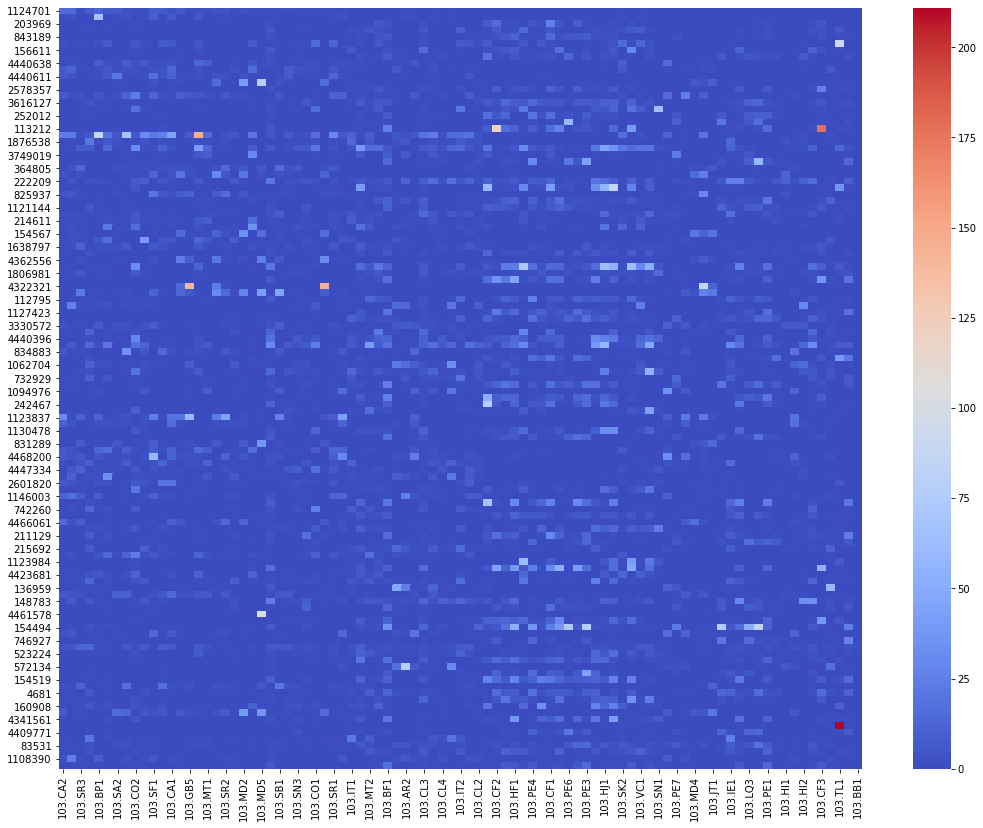

In [22]:
fig, ax = plt.subplots(figsize=(18, 14))

sns.heatmap(soil, cmap='coolwarm')
plt.show()

In [23]:
# clr = transform_features(soil_filt, transformation="mclr")
clr = transform_features(soil, transformation="mclr")
clr

,103.CA2,103.CO3,103.SR3,103.IE2,103.BP1,103.VC2,103.SA2,103.GB2,103.CO2,103.KP1,...,103.LQ1,103.HI1,103.RT1,103.HI2,103.DF1,103.CF3,103.AR1,103.TL1,103.HI4,103.BB1
1124701,3.440357,3.512415,0.962694,2.790655,3.517382,2.965674,3.024055,2.049482,1.318830,1.766831,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
697997,1.425454,2.259652,0.000000,0.000000,5.157126,0.000000,1.232296,2.049482,0.000000,1.073683,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
203969,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.515859,2.317973,0.000000,0.000000,0.000000,0.00000
205391,0.000000,0.000000,0.000000,0.711214,0.000000,1.019764,0.000000,0.000000,0.625683,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.209006,1.624825,0.000000,2.532711,0.000000,0.00000
843189,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.912508,0.000000,0.740951,0.748269,0.00000
3431064,1.830919,0.873358,0.962694,0.000000,2.051045,2.965674,0.000000,0.000000,2.235121,1.073683,...,0.000000,0.000000,0.000000,1.116390,0.000000,0.000000,0.000000,5.262740,0.000000,0.00000
156611,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.318830,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.220607,1.912508,0.000000,0.740951,0.000000,0.00000
2867534,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.376120,0.000000,0.000000,3.062300,0.822712,0.000000,0.000000,0.000000,1.846881,0.00000
4440638,0.000000,1.566505,0.000000,0.000000,3.149658,2.118376,1.232296,3.148095,2.011977,2.865443,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
216549,2.524066,3.271253,0.000000,0.711214,1.645580,2.629202,1.232296,2.337164,1.724295,1.073683,...,0.000000,0.000000,0.000000,1.116390,0.000000,0.000000,2.928015,0.000000,0.000000,0.00000


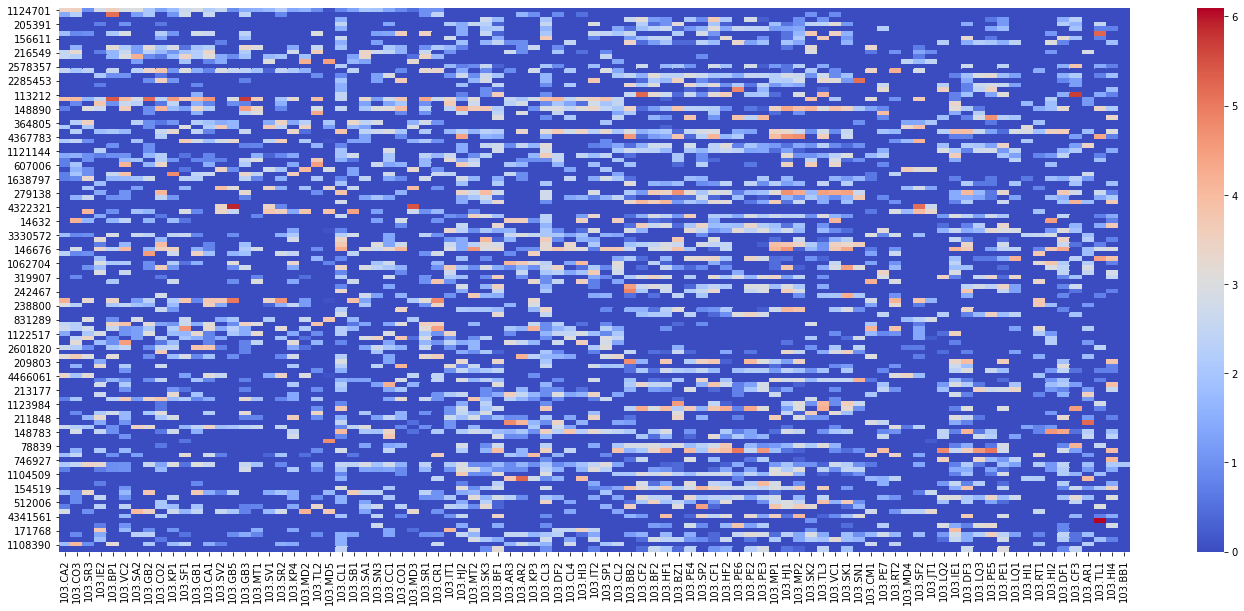

In [24]:
fig, ax = plt.subplots(figsize=(24, 10))

sns.heatmap(clr, cmap='coolwarm')
plt.show()

In [25]:
depth = soil.sum(axis=0)

meta = pd.read_table('~/GGlasso//data/soil/original/88soils_modified_metadata.txt', index_col=0)

selected_covariates = ['tot_org_carb', 'elevation', 'carb_nitro_ratio', 'annual_season_temp', 'ph']

meta = meta[selected_covariates].reindex(soil.columns)

if (meta == 0).any().any():
    print("The DataFrame contains at least one zero.")
else:
    print("The DataFrame does not contain any zeros.")



# #scale data
scaler = preprocessing.StandardScaler().fit(meta)
meta_scaled = scaler.transform(meta)
meta_scaled = pd.DataFrame(meta_scaled, index=meta.index, columns=meta.columns)

# # transpose count data
clr_T = clr.T
# join by sample id
df = clr_T.join(meta_scaled)

# # Rename long feature IDs with concise names
vis_df = df.copy()
id_dict = dict()
vis_df = add_labels(vis_df)

# #calculate covariance
n_cov = meta_scaled.shape[1]
asv = df.iloc[:, :-n_cov]
S = np.cov(asv.T.values, bias=True)

# # correlation between ASVs ONLY
corr = scale_array_by_diagonal(S)

# #add labels
asv_names = vis_df.iloc[:, :-n_cov].columns
vis_S = pd.DataFrame(corr, columns=asv_names, index=asv_names)

# # # correlation between ASVs and covariates
S_meta = np.cov(df.T.values, bias=True)
corr_meta = scale_array_by_diagonal(S_meta)
vis_S_meta = pd.DataFrame(corr_meta, columns=vis_df.columns, index=vis_df.columns)

The DataFrame does not contain any zeros.


In [26]:
width = 1500
height = 1500
label_size = "8pt"
lables_0, re_labels_0 = create_label_dict(vis_S)

p0 = _make_heatmap(data=vis_S, labels_dict=lables_0, labels_dict_reversed=re_labels_0,
                       title="Correlation: ASVs", width=width, height=height,
                       label_size=label_size)

meta_corr = vis_S_meta.iloc[-n_cov:, -n_cov:]
lables_1, re_labels_1 = create_label_dict(meta_corr)

p1 = _make_heatmap(data=meta_corr, labels_dict=lables_1, labels_dict_reversed=re_labels_1,
                       title="Correlation: covariates", width=width, height=height,
                       label_size=label_size)

vis_S_meta = vis_S_meta.T

n_cov = df.shape[1] - asv.shape[1]
lables_2, re_labels_2 = create_label_dict(vis_S_meta)

p2 = _make_heatmap(data=vis_S_meta, labels_dict=lables_2, labels_dict_reversed=re_labels_2,
                       title="Correlation: ASVs + covariates", width=width, height=height,
                       label_size=label_size)

show(p0)
show(p1)
show(p2)

In [130]:
np.logspace(1.5,-0.2, 6)

array([31.6227766 , 14.45439771,  6.60693448,  3.01995172,  1.38038426,
        0.63095734])

In [119]:
N = asv.shape[0]
p = asv.shape[1]
print("Shape of data without covariates: {0}, {1}".format(N, p))

N_meta = df.shape[0]
p_meta = df.shape[1]
print("Shape of data with covariates: {0}, {1}".format(N_meta, p_meta))

#hyperparameters
lambda1_range = np.logspace(0, -4, 20)
mu1_range = np.logspace(1.5,-0.2, 6)
# mu1_range = np.logspace(0, -2, 6)
# mu1_range = np.logspace(0, -0.1, 6)
# lambda1_range = np.logspace(0, -3, 50)
# # mu1_range = np.logspace(1.5,-0.2, 6)
# mu1_range = np.logspace(-0.2, -0.5, 10)


modelselect_params = {'lambda1_range': lambda1_range, 'mu1_range': mu1_range}

# P_SGL = glasso_problem(corr, N, latent=False, do_scaling=False)
# P_SGL.model_selection(modelselect_params=modelselect_params, method='eBIC', gamma=0.01)

P_SGL_low = glasso_problem(corr, N, latent=True, do_scaling=False)
P_SGL_low.model_selection(modelselect_params=modelselect_params, method='eBIC', gamma=0.25)

# # create lambda matrix full of zeros
# shape_meta = (p_meta, p_meta)
# mask = np.zeros(shape_meta)
# # add small constant, so ADMM could converge
# mask = mask + 0.01
# # heavy penalize species
# n_bugs = len(asv.columns)
# bugs_block = np.ones((n_bugs, n_bugs))
# mask[0:n_bugs, 0:n_bugs] += bugs_block - 0.01
# lambda1_mask_exp = mask
# df_mask_exp = pd.DataFrame(lambda1_mask_exp, columns=vis_df.columns, index=vis_df.columns)

# modelselect_params["lambda1_mask"] = lambda1_mask_exp
# P_SGL_adapt = glasso_problem(vis_S_meta.values, N_meta, latent=False, do_scaling=False)
# P_SGL_adapt.model_selection(modelselect_params=modelselect_params, method='eBIC', gamma=0.01)

Shape of data without covariates: 89, 116
Shape of data with covariates: 89, 121
ADMM terminated after 36 iterations with status: optimal.
ADMM terminated after 40 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 56 iterations with status: optimal.
ADMM terminated after 57 iterations with status: optimal.
ADMM terminated after 47 iterations with status: optimal.
ADMM terminated after 41 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 56 iterations with status: optimal.
ADMM terminated after 57 iterations with status: optimal.
ADMM terminated after 161 iterations with status: optimal.
ADMM terminated after 60 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 27 iterations with status:

In [120]:
print("SGL solution with lambda={lambda1} and mu={mu1}".format(**P_SGL.reg_params))
print("Adaptive SGL+low-rank solution with lambda={lambda1} and mu={mu1}".format(**P_SGL_adapt.reg_params))
print("SGL+low-rank solution with lambda={lambda1} and mu={mu1}".format(**P_SGL_low.reg_params))

SGL solution with lambda=0.14384498882876628 and mu=0
Adaptive SGL+low-rank solution with lambda=0.14384498882876628 and mu=0
SGL+low-rank solution with lambda=0.23357214690901226 and mu=6.606934480075961


In [59]:
P_SGL.modelselect_stats

{'BIC': {0.1: array([[10324.        ],
         [ 9991.88912542],
         [ 8878.76359402],
         [ 8250.77186867],
         [ 8692.36657947],
         [ 9771.07281066],
         [11798.11605599],
         [14672.63791987],
         [17581.94761547],
         [20499.49672925],
         [23253.46270196],
         [24941.80720081],
         [26199.34686581],
         [26670.39080573],
         [27027.46001367],
         [27029.80993786],
         [26667.82059521],
         [26122.52717424],
         [25772.0486548 ],
         [25138.54207604]]),
  0.5: array([[10324.        ],
         [11429.37479921],
         [13449.81592179],
         [14213.67540439],
         [16784.87852081],
         [20708.13312236],
         [26720.58638391],
         [34675.74544405],
         [42734.14403465],
         [50755.1475776 ],
         [58346.36692879],
         [63548.5652969 ],
         [67757.13375254],
         [70220.88270057],
         [72388.11905329],
         [73721.47423099],
         

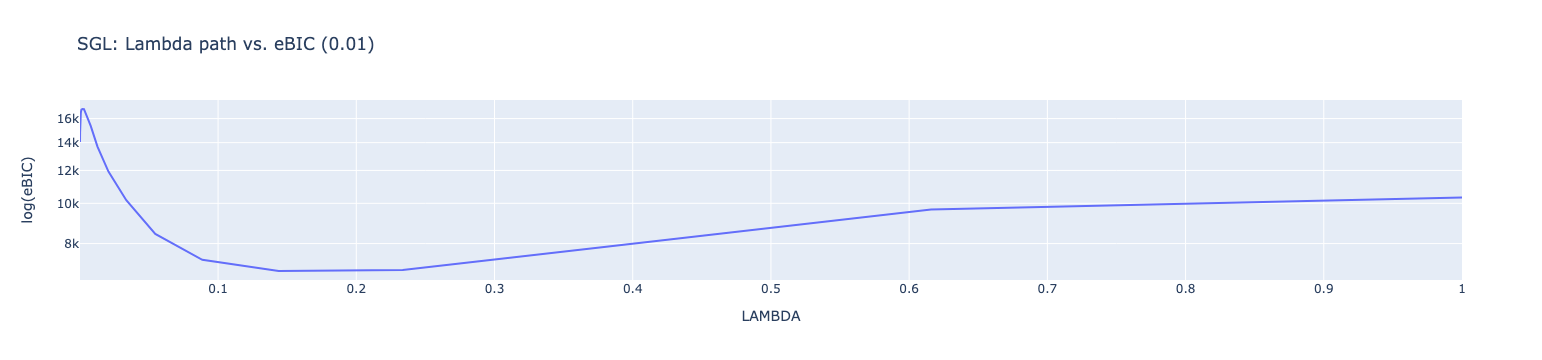

In [182]:
x = P_SGL.modelselect_stats['BIC'][0.01]
y = P_SGL.modelselect_stats['LAMBDA']

trace = go.Scatter(x=y.flatten(), y=x.flatten(), mode='lines')
data = [trace]

layout = go.Layout(title='SGL: Lambda path vs. eBIC ({0})'.format(0.01), xaxis_title='LAMBDA', yaxis_title='log(eBIC)', yaxis_type='log')
fig = go.Figure(data=data, layout=layout)
fig.show()

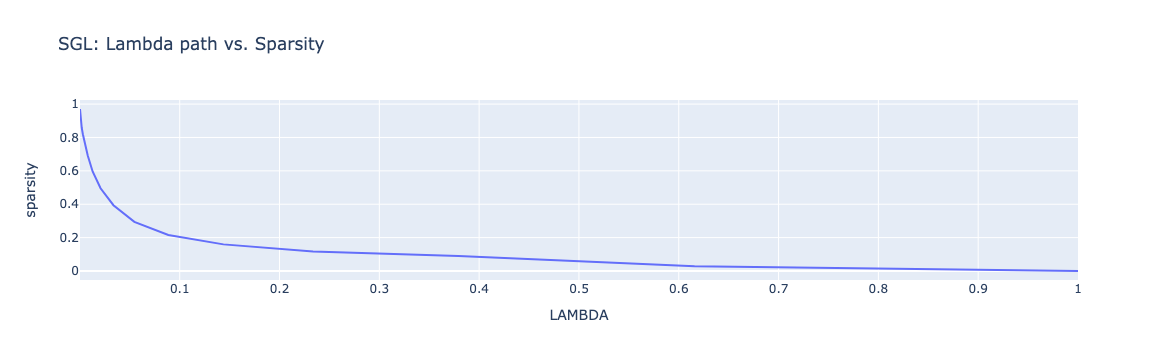

In [122]:
x = P_SGL.modelselect_stats['SP']
y = P_SGL.modelselect_stats['LAMBDA']

trace = go.Scatter(x=y.flatten(), y=x.flatten(), mode='lines')
data = [trace]

layout = go.Layout(title='SGL: Lambda path vs. Sparsity', xaxis_title='LAMBDA', yaxis_title='sparsity')
fig = go.Figure(data=data, layout=layout)
fig.show()

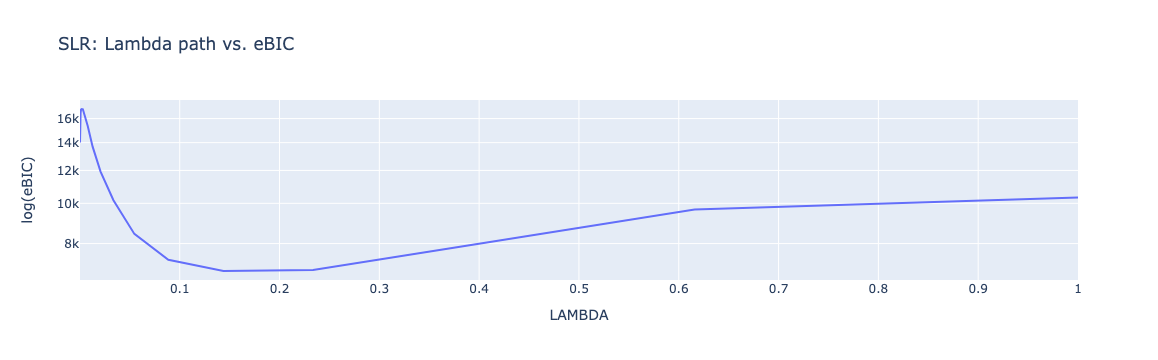

In [123]:
x = P_SGL_low.modelselect_stats['BIC'][0.01][:, 0]
y = P_SGL_low.modelselect_stats['LAMBDA'][:, 0]

trace = go.Scatter(x=y.flatten(), y=x.flatten(), mode='lines')
data = [trace]

layout = go.Layout(title='SLR: Lambda path vs. eBIC', xaxis_title='LAMBDA', yaxis_title='log(eBIC)', yaxis_type='log')
fig = go.Figure(data=data, layout=layout)
fig.show()

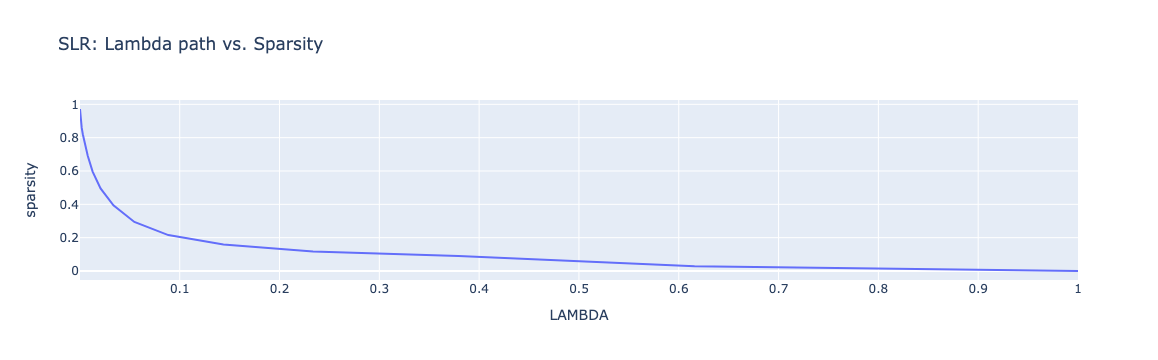

In [124]:
x = P_SGL_low.modelselect_stats['SP'][:, 0]
y = P_SGL_low.modelselect_stats['LAMBDA'][:, 0]

trace = go.Scatter(x=y.flatten(), y=x.flatten(), mode='lines')
data = [trace]

layout = go.Layout(title='SLR: Lambda path vs. Sparsity', xaxis_title='LAMBDA', yaxis_title='sparsity')
fig = go.Figure(data=data, layout=layout)
fig.show()

In [125]:
L = P_SGL_low.solution.lowrank_
r = np.linalg.matrix_rank(L)
r

3

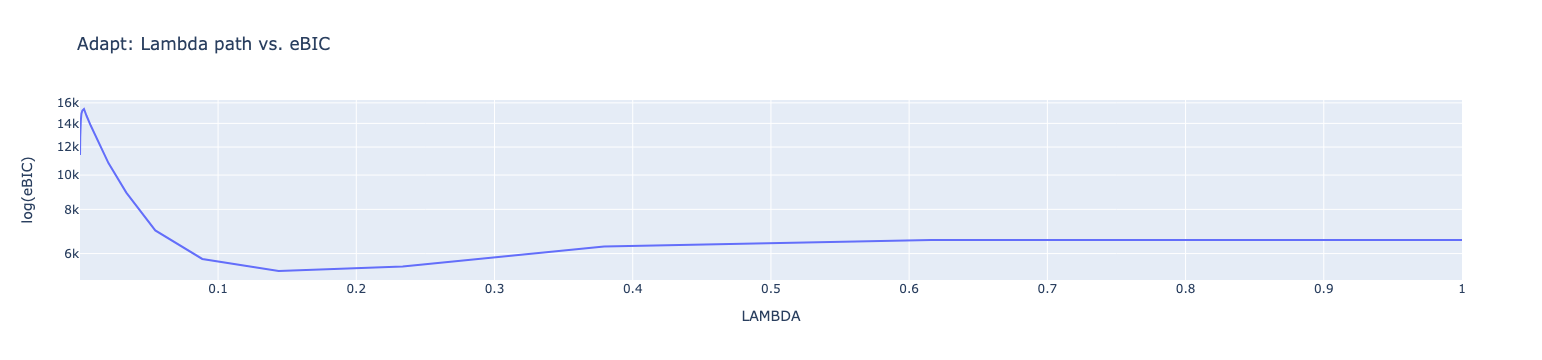

In [163]:
x = P_SGL_adapt.modelselect_stats['BIC'][0.01][:, 0]
y = P_SGL_adapt.modelselect_stats['LAMBDA'][:, 0]

trace = go.Scatter(x=y.flatten(), y=x.flatten(), mode='lines')
data = [trace]

layout = go.Layout(title='Adapt: Lambda path vs. eBIC', xaxis_title='LAMBDA', yaxis_title='log(eBIC)', yaxis_type='log')
fig = go.Figure(data=data, layout=layout)
fig.show()

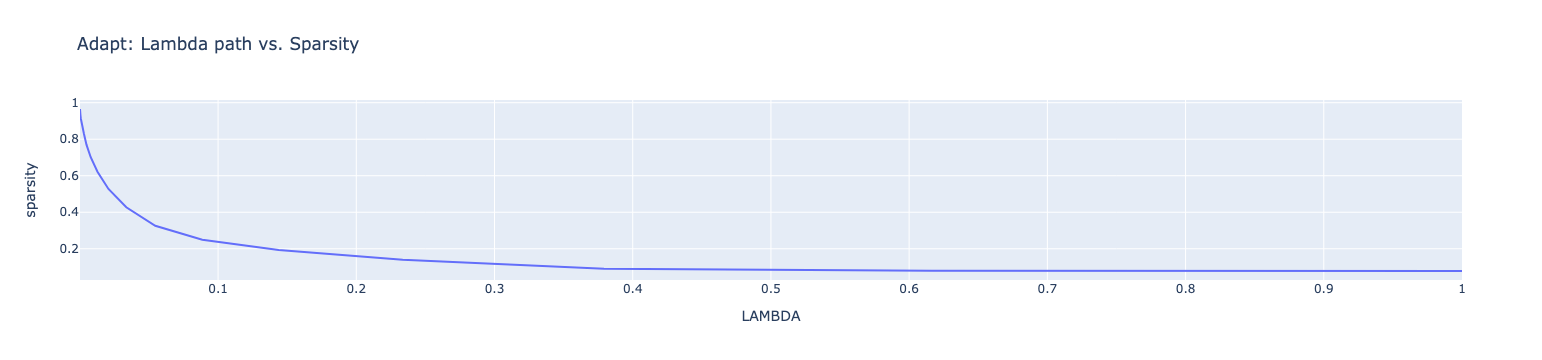

In [165]:
x = P_SGL_adapt.modelselect_stats['SP'][:, 0]
y = P_SGL_adapt.modelselect_stats['LAMBDA'][:, 0]

trace = go.Scatter(x=y.flatten(), y=x.flatten(), mode='lines')
data = [trace]

layout = go.Layout(title='Adapt: Lambda path vs. Sparsity', xaxis_title='LAMBDA', yaxis_title='sparsity')
fig = go.Figure(data=data, layout=layout)
fig.show()

In [126]:
test = pd.DataFrame(L)

test.shape
# width = 1500
# height = 1500
# label_size = "8pt"
# lables_0, re_labels_0 = create_label_dict(test)

# p_test = _make_heatmap(data=vis_S, labels_dict=lables_0, labels_dict_reversed=re_labels_0,
#                        title="Low-rank: ASVs", width=width, height=height,
#                        label_size=label_size)

# show(p_test)

(116, 116)

In [131]:
width = 1500
height = 1500
label_size = "8pt"

# for visualization reasons we transform inverse covaraince to negative inverse covaraince, i.e., multiply by -1
sgl = -1 * pd.DataFrame(P_SGL.solution.precision_, columns=asv_names, index=asv_names)
adapt = -1 * pd.DataFrame(P_SGL_adapt.solution.precision_, columns=vis_df.columns, index=vis_df.columns)
low = -1 * pd.DataFrame(P_SGL_low.solution.precision_, columns=asv_names, index=asv_names)


lables_sgl, re_labels_sgl = create_label_dict(sgl)
lables_adapt, re_labels_adapt = create_label_dict(adapt)
lables_low, re_labels_low = create_label_dict(low)

p_sgl = _make_heatmap(data=sgl, labels_dict=lables_sgl, labels_dict_reversed=re_labels_sgl,
                       title="SGL estimated (negative) inverse covariance", width=width, height=height,
                       label_size=label_size)

p_adapt = _make_heatmap(data=adapt, labels_dict=lables_adapt, labels_dict_reversed=re_labels_adapt,
                       title="Adaptive estimated (negative) inverse covariance", width=width, height=height,
                       label_size=label_size)

p_low = _make_heatmap(data=low, labels_dict=lables_low, labels_dict_reversed=re_labels_low,
                       title="SGL+low-rank estimated (negative) inverse covariance", width=width, height=height,
                       label_size=label_size)
show(p_sgl)
show(p_adapt)
show(p_low)

In [155]:
# meta_cols = list(adapt.iloc[:, -n_cov:].columns)
# asv95_sgl = ["ASV_95", "ASV_24", "ASV_30", "ASV_31", "ASV_58", "ASV_66", "ASV_92", "ASV_102", "ASV_105", "ASV_111"]
# asv95_low =[ "ASV_95", "ASV_24",           "ASV_31",           "ASV_66", "ASV_92",            "ASV_105", "ASV_111"]
# asv95_adapt = meta_cols + asv95_sgl

# meta_cols = list(adapt.iloc[:, -n_cov:].columns)
# asv95_sgl = ["ASV_97", "ASV_6", "ASV_18", "ASV_19", "ASV_25", "ASV_31", "ASV_32", "ASV_94", "ASV_104", "ASV_107", "ASV_113"]
# asv95_low =[ "ASV_97",          "ASV_18", "ASV_19", "ASV_25",           "ASV_32",                      "ASV_107", "ASV_113"]
# asv95_adapt = meta_cols + asv95_sgl

meta_cols = list(adapt.iloc[:, -n_cov:].columns)
# asv95_sgl = ["ASV_95", "ASV_5", "ASV_15", "ASV_17", "ASV_18", "ASV_24", "ASV_30", "ASV_32", "ASV_57", "ASV_92", "ASV_102", "ASV_105", "ASV_111"]
asv95_sgl = ["ASV_95",  "ASV_15",  "ASV_24"] # drop edges for vis 
# asv95_adapt = meta_cols + asv95_sgl
asv95_adapt = asv95_sgl + ['ph']

sgl_edges = sgl[sgl.columns.intersection(asv95_sgl)].loc[asv95_sgl]
adapt_edges = adapt[adapt.columns.intersection(asv95_adapt)].loc[asv95_adapt]
low_edges = low[low.columns.intersection(asv95_sgl)].loc[asv95_sgl]


G_SGL = create_graph(sgl_edges, threshold=0.1)
G_adapt = create_graph(adapt_edges, threshold=0.1)
G_low = create_graph(low_edges, threshold=0.1)


# G_SGL = create_graph(sgl, threshold=0.1)
# G_adapt = create_graph(adapt, threshold=0.1)
# G_low = create_graph(low, threshold=0.1)


width, height= 1000, 1000

network_sgl = plot_network(G_SGL, title="SGL", height=height, width=width, amplify_x=50)
network_adapt = plot_network(G_adapt, title="Adaptive", height=height, width=width, amplify_x=50)
network_low = plot_network(G_low, title="Low-rank",  height=height, width=width, amplify_x=50)

# show(network_sgl)
show(network_adapt)
# show(network_low)

In [139]:
# p_66_31 = scater_plot(vis_df["ASV_95"], vis_df["ASV_58"])
# p_18_temp = scater_plot(vis_df["ASV_95"], vis_df["ph"])
# p_51_temp = scater_plot(vis_df["ASV_58"], vis_df["ph"])

p_95_15 = scater_plot(vis_df["ASV_95"], vis_df["ASV_15"])
p_95_ph = scater_plot(vis_df["ASV_95"], vis_df["ph"])
p_15_ph = scater_plot(vis_df["ASV_15"], vis_df["ph"])

show(p_95_15)
show(p_95_ph)
show(p_15_ph)

In [178]:
vis_df["ASV_95"].shape

(89,)

In [181]:
# inv_ph = adapt['ph'][:-n_cov]
# a = adapt["ASV_95"][:-n_cov]
# b = adapt["ASV_15"][:-n_cov]

# p_95_inv_ph = scater_plot(a, inv_ph)
# p_15_inv_ph = scater_plot(b, inv_ph)
# show(p_95_inv_ph)
# show(p_15_inv_ph)

In [ ]:
raw = soil.T.copy()

i = 1
for col in raw.columns:
    # length of ASVs identifier
    if col.isdigit():
        asv_name = "ASV_{0}".format(i)
        raw.rename(columns={col: asv_name}, inplace=True)

        i += 1
        

asv_66 = raw['ASV_95']
asv_31 = raw['ASV_58']

In [ ]:
asv_31.values

In [ ]:
asv_66.values

In [ ]:
plt.plot(asv_66, asv_31, 'o', color='black');

In [132]:
inv_cov = adapt.iloc[:-n_cov, -n_cov:]

L_adapt = inv_cov @ inv_cov.T
L_adapt.shape

L_1 = pd.DataFrame(P_SGL_low.solution.lowrank_, columns=asv_names, index=asv_names)
L_2 = pd.DataFrame(L_adapt, columns=asv_names, index=asv_names)

r1 = np.linalg.matrix_rank(L_1)
r2 = np.linalg.matrix_rank(L_2)

print("L1-rank: {0}".format(r1))
print("L2-rank: {0}".format(r2))

proj_1, loadings_1, eigv_1 = PCA(asv, L_1, inverse=True)

eigv_sum_1 = np.sum(eigv_1)
var_exp_1 = [(value / eigv_sum_1) for value in sorted(eigv_1, reverse=True)]

proj_2, loadings_2, eigv_2 = PCA(asv, L_2, inverse=True)

eigv_sum_2 = np.sum(eigv_2)
var_exp_2 = [(value / eigv_sum_2) for value in sorted(eigv_2, reverse=True)]

pca_plot = project_covariates(asv, metadata=meta_scaled, L=L_1, y='ph')
show(pca_plot)

L1-rank: 3
L2-rank: 5


In [133]:
width = 1500
height = 1500
label_size = "8pt"

adapt_theta = adapt.copy()

asv_cov = adapt_theta.iloc[:-n_cov, -n_cov:]

l1_norm = np.linalg.norm(asv_cov.values, axis=1)

adapt_theta['l1'] = np.append(l1_norm, np.zeros(n_cov))

adapt_theta = adapt_theta.T

adapt_theta['l1'] = np.append(l1_norm, np.zeros(n_cov+1))
adapt_theta = adapt_theta.sort_values(by=['l1'], ascending=False)
adapt_theta = adapt_theta.T
adapt_theta = adapt_theta.sort_values(by=['l1'], ascending=False)

lables_l1, re_labels_l1 = create_label_dict(adapt_theta)

p_l1 = _make_heatmap(data=adapt_theta, labels_dict=lables_l1, labels_dict_reversed=re_labels_l1,
                       title="Esatimated inverse covariance sorted by l1-norm of the covariates", width=width, height=height,
                       label_size=label_size)
show(p_l1)

In [157]:
sorted_order = adapt_theta.index[:-n_cov-1].values

width = 1500
height = 1500
label_size = "8pt"

# for visualization reasons we transform inverse covaraince to negative inverse covaraince, i.e., multiply by -1
sgl = -1 * pd.DataFrame(P_SGL.solution.precision_, columns=asv_names, index=asv_names)
adapt = -1 * pd.DataFrame(P_SGL_adapt.solution.precision_, columns=vis_df.columns, index=vis_df.columns)
low = -1 * pd.DataFrame(P_SGL_low.solution.precision_, columns=asv_names, index=asv_names)


sorted_sgl = sgl.reindex(index=sorted_order).T.reindex(index=sorted_order).T
sorted_low = low.reindex(index=sorted_order).T.reindex(index=sorted_order).T

sorted_lables_sgl, sorted_re_labels_sgl = create_label_dict(sorted_sgl)
sorted_lables_low, sorted_re_labels_low = create_label_dict(sorted_low)

sorted_p_sgl = _make_heatmap(data=sorted_sgl, labels_dict=sorted_lables_sgl, labels_dict_reversed=sorted_re_labels_sgl, # multiply by 3 for making edge visible on the heatmao
                       title="SGL estimated (negative) inverse covariance sorted by l1", width=width, height=height,
                       label_size=label_size)

sorted_p_low = _make_heatmap(data=sorted_low, labels_dict=sorted_lables_low, labels_dict_reversed=sorted_re_labels_low,
                       title="SGL+low-rank estimated (negative) inverse covariance sorted by l1", width=width, height=height,
                       label_size=label_size)
show(sorted_p_sgl)
show(sorted_p_low)

/Users/oleg.vlasovetc/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



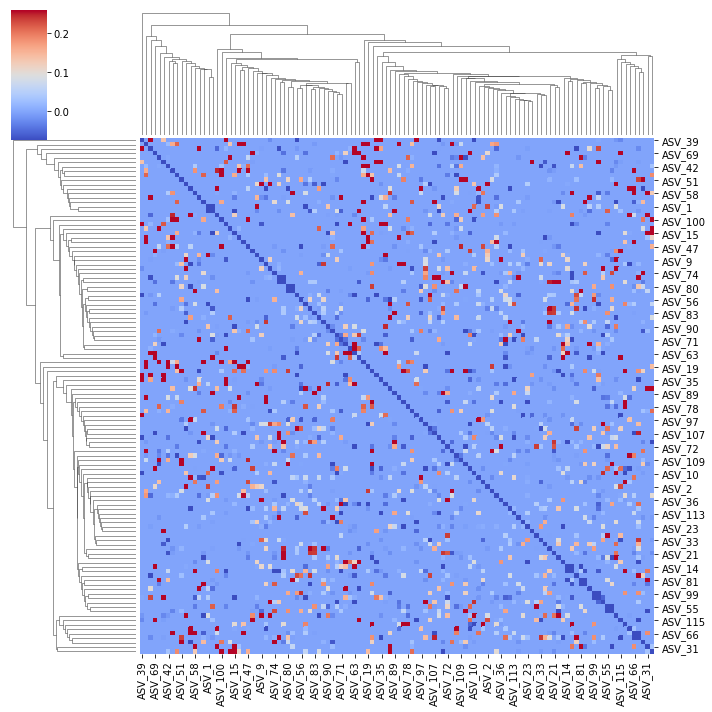

In [158]:
import seaborn as sns
import pandas as pd
import numpy as np

# Create a random dataset
# data = pd.DataFrame(np.random.rand(10, 10), columns=list('ABCDEFGHIJ'))

# Create a clustegram using seaborn.clustermap()
g = sns.clustermap(sgl, cmap='coolwarm', metric='euclidean', method='complete', robust=True)

# Show the plot
plt.show()

In [161]:
g.__dict__

{'data':             ASV_1     ASV_2     ASV_3     ASV_4     ASV_5     ASV_6     ASV_7  \
 ASV_1   -1.546554  0.150884 -0.000000 -0.000000 -0.000000  0.000000 -0.000000   
 ASV_2    0.150884 -1.342084  0.000000 -0.000000  0.000000  0.000000  0.000000   
 ASV_3   -0.000000  0.000000 -1.775484  0.000000  0.177947  0.000000  0.000000   
 ASV_4   -0.000000 -0.000000  0.000000 -1.573765 -0.000000  0.000000  0.000000   
 ASV_5   -0.000000  0.000000  0.177947 -0.000000 -1.834463  0.000000  0.000000   
 ASV_6    0.000000  0.000000  0.000000  0.000000  0.000000 -1.443275 -0.000000   
 ASV_7   -0.000000  0.000000  0.000000  0.000000  0.000000 -0.000000 -1.357455   
 ASV_8   -0.000000 -0.000000  0.000000 -0.000000  0.000000 -0.000000 -0.000000   
 ASV_9    0.000000  0.076396 -0.000000  0.000000 -0.000000  0.000000  0.000000   
 ASV_10   0.142237  0.000000 -0.000000 -0.000000 -0.000000  0.000000 -0.000000   
 ASV_11   0.533259  0.067488  0.000000 -0.000000 -0.000000  0.000000 -0.000000   
 ASV_12 

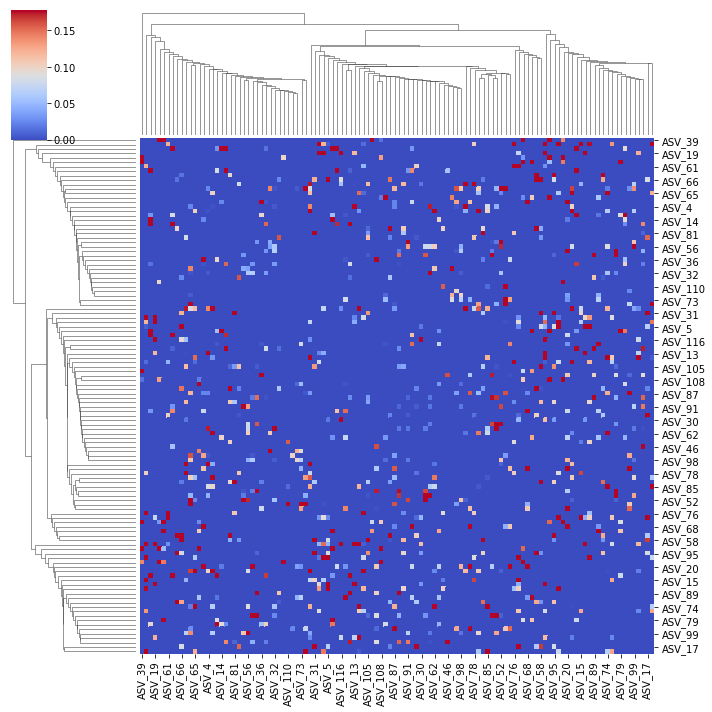

In [159]:
# Create a clustegram using seaborn.clustermap()
g = sns.clustermap(low, cmap='coolwarm', metric='euclidean', method='complete', robust=True)

# Show the plot
plt.show()